# Import Library

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import mixture
from sklearn import preprocessing
from scipy import interpolate
from collections import Counter
# from mpl_toolkits.mplot3d import Axes3D

# Data Preprocess
### Reading data

In [182]:
def read_data(folder):
    data = pd.DataFrame()
    for i in range(1,303):
        file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + "_Step" + str(i) + ".csv"
        tmp = pd.read_csv(file_path)
        force = np.sqrt(tmp["F_x"]**2 + 
                        tmp["F_y"]**2 + 
                        tmp["F_z"]**2)
        data[str(i)] = force
    data.insert(0, "part_num", tmp["part_num"])
    data.insert(1, "x", tmp["centroid_x"])
    data.insert(2, "y", tmp["centroid_y"])
    data.insert(3, "z", tmp["centroid_z"])
    
    return data

folder = "cb_d16out"
data = read_data(folder)
# data

### Utility functions

In [54]:
def preprocess(df):
    min_value = 1e-5
    df.iloc[:,4:] = np.log(df.iloc[:,4:] + min_value)
    
    return df

# data_precess = preprocess(data)

### EDA (exploratory data analysis)

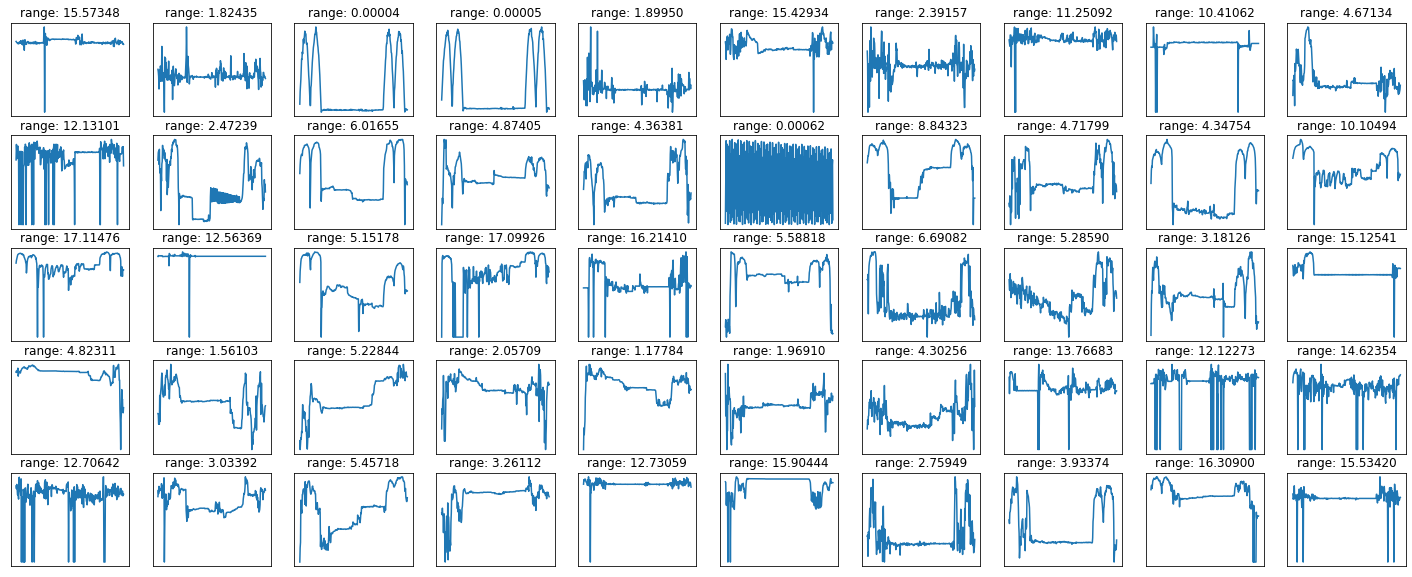

In [56]:
# show force change with time
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(50):
    ax = fig.add_subplot(5, 20/2, idx+1, xticks=[], yticks=[])
    ax.plot(data.iloc[idx,4:])
    force_range = max(data.iloc[idx,4:]) - min(data.iloc[idx,4:]) 
    ax.set_title("range: {0:.5f}".format(force_range))


# Spline Regression

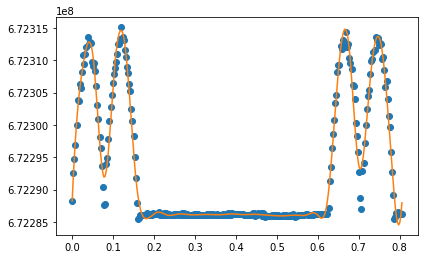

In [184]:
time_interval = 0.000002896586623472
record_per_step = 921
total_time = time_interval * record_per_step * 302
x = np.linspace(0, total_time, num = 302)
y = data.iloc[2, 4:]

knot_num = 30
knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)

tck = interpolate.splrep(x, y, task = -1, k = 3, t = knots)
spline = interpolate.splev(x, tck)
xs = np.arange(0, 279639*time_interval, 0.1)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(x, spline, label="S")

# tck
# https://en.wikipedia.org/wiki/De_Boor%27s_algorithm

### Choose knot number

In [201]:
total_particle = len(data)
time_interval = 0.000002896586623472
record_per_step = 921
total_time = time_interval * record_per_step * 302

# divided into 10 groups
group = np.random.randint(1, 11, size = 303)
print(group)
# x = np.linspace(0, total_time, num = 302)
# y = data.iloc[2, 4:]

# knot_num = 30
# knots = np.linspace(total_time * 1/(knot_num + 1), total_time * knot_num / (knot_num + 1), num = knot_num)

# tck = interpolate.splrep(x, y, task = -1, k = 3, t = knots)
# spline = interpolate.splev(x, tck)
# xs = np.arange(0, 279639*time_interval, 0.1)

# fig, ax = plt.subplots(figsize=(6.5, 4))
# ax.plot(x, y, 'o', label='data')
# ax.plot(x, spline, label="S")


[ 8  2  7  3  2  4  6  7  7  5  4  6  5 10  3  3  9  4  4  1  6  8  1  7
  8  4  7  1  4  9  9  7  5  9  4 10  2  9  6  9  2 10  8  4  8  1  3  7
  3  6  7  8  6  7  3  4  5  8  9  6  9  7  3  1  8  9  6  7  4  6 10  3
  4  2 10  1  8 10  3  5  3  5  6  3  9  3  7  4  5  3  8  7  5  5 10  6
  8  7  8  1  1  9  8  9  5  6  2 10  4  2  8  4  8  3  6  4  6  5  3  1
  4  3  5 10  8  6  6  8 10  6 10  6  7  2  1  8 10  2  5  7  8  5 10  5
  4  9  2  5  9  4  5  8  1  9  2  7  2  7  7  6 10 10  3  3  6  3  4  1
  3 10  4  6  6  7  4  9  5  4  9  1  5  9  4  1  7  1  8  7  1 10 10  9
  1  5  8  6  7  5  3  9 10  8  4  5 10  9 10  9  2  3 10  6  4  1  2  7
 10  2  9  2  8  2  8  5 10  7  2  7  1  6 10  9  7  9  6  9  1  2  9  3
  3  1  2  2  4  1  5  8  1  9  2  3  4  8  2 10  1  2 10 10  2  6  9  8
  5  1 10  2  8  2  7  9 10  3  5 10  3  7 10  6  2 10  4 10  7 10  3  6
  4 10  6  7  8  9  9  7  9  6 10  4 10  7  8]
